In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import gamma, beta
from scipy.integrate import dblquad
from scipy.stats import gaussian_kde, norm
from scipy.interpolate import interp1d



import importlib

import base, bivariate, marginals, utils, tests, plots

importlib.reload(base)
importlib.reload(utils)
importlib.reload(bivariate)
importlib.reload(marginals)
importlib.reload(tests)
importlib.reload(plots)


plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 75

In [4]:
#model = bivariate.StudentT(df = 5, Q = 0.7)
#model = bivariate.BivariateNormalMix(Q1 = 0.5, Q2 = -0.25, p = 0.1, adj = 1e-2)
model1 = bivariate.StudentsT(Q = 0.5, df = 10)
#model2 = bivariate.Normal(Q = 0.5)

#model = bivariate.Clayton(alpha = 0.5)
#model = bivariate.Gumbel(delta = 1)

#model1 = bivariate.Normal(Q = 0.3)

In [9]:
#u1_sim, u2_sim = bivariate.StudentT(df = 5, Q = 0.9).simulate(n = 10000)

#model = bivariate.Gumbel(delta = 1.5)
#u1_sim, u2_sim = model2.simulate(n = 500)

#model2 = bivariate.StudentT()
#model2.fit(u1_sim, u2_sim)

u1_sim, u2_sim = model1.simulate(n = 500)

model2 = bivariate.StudentsT()
model2.fit(u1_sim, u2_sim)

In [10]:
print(model2.summary())

                           Bivariate Copula Summary                           
Model Name:                  StudentT   Log-Likelihood:                92.5692
Model Family:              Elliptical   AIC:                          -88.5692
Method:                          CMLE   BIC:                         -172.7092
Num. Params:                        2   Kendall's Tau:                  0.3685
Num. Obs:                         500   Spearman's Rho:                    nan
Date:                Thu, Feb 08 2024   Upper Tail Depend.:                 NA
Time:                        22:07:45   Lower Tail Depend.:                 NA
                                                                              
                                                                              
                              Parameter Estimates                              
             coef    std err       h0          t       P>|t|     95% Conf. Int.
--------------------------------------------------

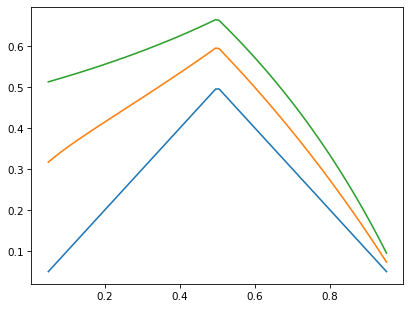

In [14]:
q_range = utils.get_u_range(5e-2, range_num = 100)

f, ax = plt.subplots()
ax.plot(q_range, np.where(q_range > 0.5, 1 - q_range, q_range))

Q = -0.5
models = [bivariate.Clayton(alpha = 0.5),
          bivariate.Clayton(alpha = 1)]


for model in models:
    ax.plot(q_range, model.quantile_dependance(q_range))
    


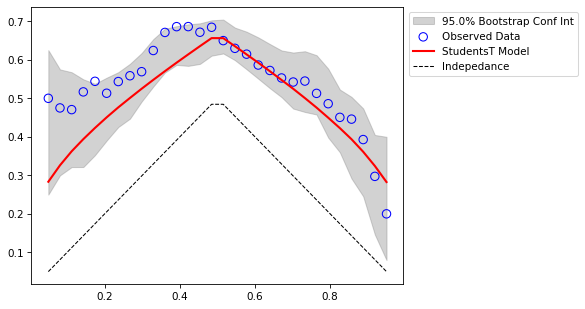

In [16]:
ax = plots.quantile_dependance(u1_sim, u2_sim, copula = model1, copula_label = "StudentsT Model", 
                               show_indep = True, boot = True)

In [1017]:
#print(model2.summary())

In [1018]:
#marginal1 = marginals.StudentT(mean = 2, stdev = 1)
#x1 = marginal1.simulate(n = 1000)


#marginal2 = marginals.StudentT()
#marginal2.fit(x1)

In [1019]:
#print(marginal2.summary())

In [17]:
copula = bivariate.Clayton(alpha = 0.5)
u1, u2 = utils.get_u_grid()

<Axes3DSubplot:>

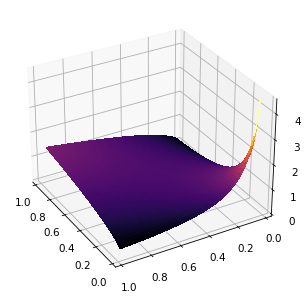

In [20]:
plots.copula_3d_surf(copula, adj = 3e-2, azim = 150, elev = 30, cmap = "inferno")

<AxesSubplot:>

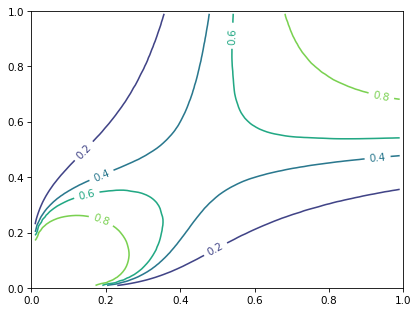

In [21]:
plots.copula_contour(copula, num_levels = 5)

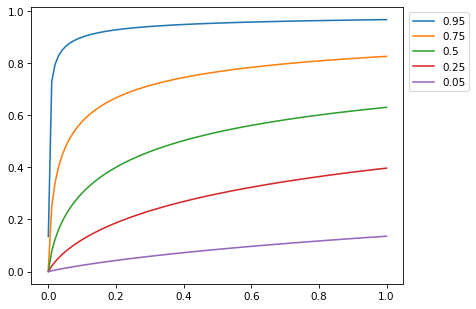

In [22]:
ax = plots.copula_quantile_curves(copula)

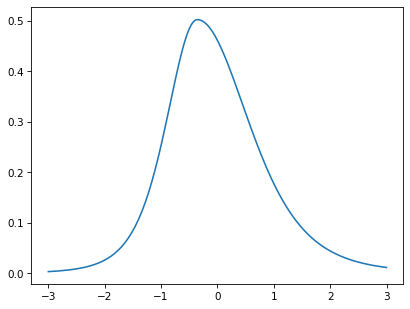

In [55]:
def skew_student_t(z, eta, lam):
    const_C = gamma((eta + 1) / 2) / (np.sqrt(np.pi * (eta - 2)) * gamma(eta / 2))
    const_A = 4 * lam * const_C * (eta - 2) / (eta - 1)
    const_B = np.sqrt(1 + 3 * (lam**2) - (const_A ** 2))
    denom = np.where(z < -const_A/const_B, 1 - lam, 1 + lam)
    return const_B * const_C * np.power((1 + 1/(eta -2) * np.square((const_B * z + const_A)/denom)), -(eta+1)/2)


def sktcdf(z,nu,_lambda):
    '''
    % sktcdf(z,nu,lambda)
    % z      = Random Variable value (Between -inf and inf)
    % nu     = Kurtosis Parameter (>2 to inf)
    % lambda = Assymetry Parameter (-1 to 1)
    %
    % returns u = random Variable (between 0 and 1)
    %
    % Calculates the CDF for the skewed Student-t. Hansen (1994) version.
    % Author: Tino Contino
    % Date:   2 May 2021
    '''
    
    z  = np.atleast_1d(z)
    
    c = gamma((nu+1)/2)/(np.sqrt(np.pi*(nu-2))*gamma(nu/2))
    a = 4*_lambda*c*((nu-2)/(nu-1))
    b = np.sqrt(1 + 3 * _lambda**2 - a**2)
    
    limit_variable = -a/b
    lt = z < limit_variable
    gt = z >= limit_variable
    
    
    
    y_1 = (b*z+a) / (1-_lambda) * np.sqrt(nu/(nu-2))
    y_2 = (b*z+a) / (1+_lambda) * np.sqrt(nu/(nu-2))
    
    pdf1 = (1-_lambda) * stats.t.cdf(y_1, nu)
    pdf2 = (1-_lambda)/2 + (1+_lambda) * (stats.t.cdf(y_2, nu)-0.5)

    u = z.copy()

    u[lt] = pdf1[lt]
    u[gt] = pdf2[gt]

    return u

x_range = np.linspace(-3, 3, 200)

marginal = marginals.StandardSkewedT(5, 0.25)

pdf = skew_student_t(x_range, 5, 0.25)
f, ax = plt.subplots()
ax.plot(x_range, pdf)

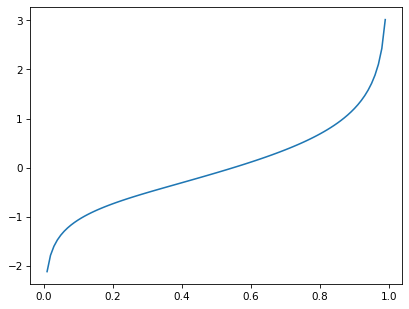

In [56]:
u_range = utils.get_u_range(adj = 1e-2)

f, ax = plt.subplots()
ax.plot(u_range, marginal.ppf(u_range))

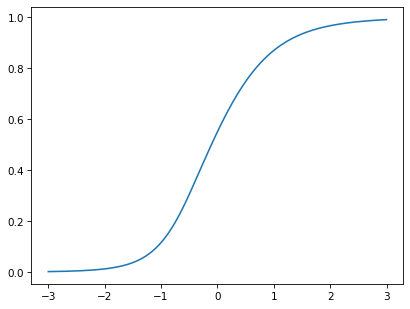

In [57]:
plt.plot(x_range, sktcdf(x_range, 5, 0.25))
#plt.plot(x_range, sktcdf(x_range, 5, 0.9))

In [144]:
C = marginal.ppf(0.5)
x =  marginal.cdf(C)

AttributeError: 'GaussianKDE' object has no attribute 'interp1d_ppf_func'

NameError: name 'skew_generalized_t' is not defined

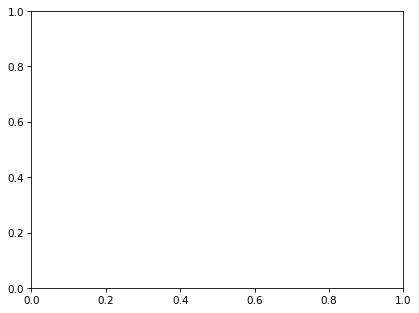

In [65]:
f, ax = plt.subplots()

pdf = skew_generalized_t(x_range, 0, 1, -0.25, 2, 1000)
ax.plot(x_range, pdf)

In [ ]:
def skew_generalized_t(x, mu, sigma, lam, p, q):
    v = q**(-1/p) * ((3*lam**2 + 1)*(beta(3/p, q - 2/p)/beta(1/p,q)) - 4*lam**2*(beta(2/p, q - 1/p)/beta(1/p,q))**2)**(-1/2)

    m = 2*v*sigma*lam*q**(1/p)*beta(2/p,q - 1/p)/beta(1/p,q)   

    fx = p  / (2*v*sigma*q**(1/p)*beta(1/p,q)*(abs(x-mu+m)**p/(q*(v*sigma)**p)*(lam*np.sign(x-mu+m)+1)**p + 1)**(1/p + q))

    return fx

In [192]:
data = np.random.normal(size = 100)

In [193]:
stats.gaussian_kde(data)

In [194]:
marginal = marginals.GaussianKDE()
marginal.fit(data)


x_range = np.linspace(np.min(data), np.max(data))

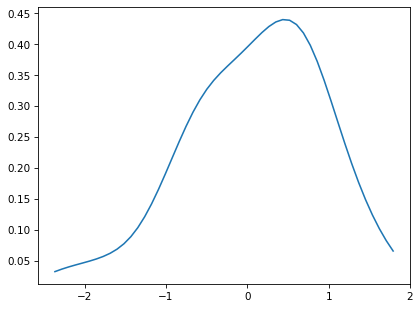

In [195]:
plt.plot(x_range, marginal.pdf(x_range))

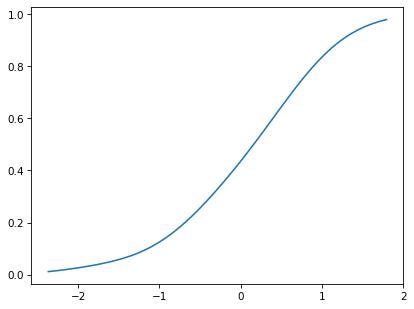

In [196]:
plt.plot(x_range, marginal.cdf(x_range))

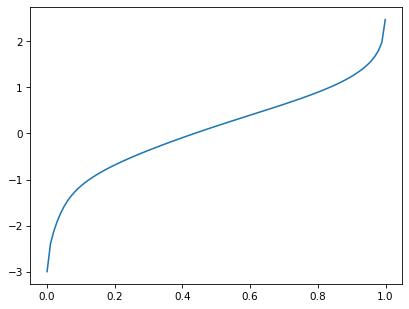

In [197]:
plt.plot(utils.get_u_range(), marginal.ppf(utils.get_u_range()))

In [177]:
marginal.ppf(0.999)

array(18.63322863)

In [132]:
# Compute CDF by cumulatively summing the PDF values and normalizing
cdf_values = np.cumsum(pdf_values)
cdf_values /= cdf_values[-1]



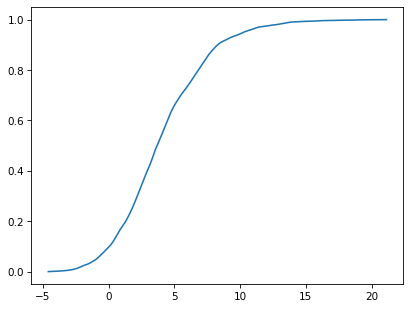

In [133]:
plt.plot(x_range, cdf_values)

In [134]:
# Interpolate the CDF for inverse lookup (PPF)
ppf_function = interp1d(cdf_values, x_range, bounds_error=False, fill_value=(x_range[0], x_range[-1]))

In [137]:
ppf_function(np.array([0.25, 0.5, 0.9]))

array([1.77875307, 3.68195613, 8.28825372])

In [ ]:
# Example: Find the 25th, 50th, and 75th percentiles
percentiles = [0.25, 0.5, 0.75]
ppf_values = [ppf_function(p) for p in percentiles]

print(f"25th percentile: {ppf_values[0]}, 50th percentile: {ppf_values[1]}, 75th percentile: {ppf_values[2]}")